# **Fixed fraction of neutral agents - impact of parameter alpha**

This notebook corresponds to the section where we introduce a fixed fraction of neutral agents into our spin system simulation. The goal is to analyze the impact of the parameter alpha on the system's dynamic.

## I. Basic imports and setup

In [17]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from numpy import empty, nan, savetxt
import random
from scipy import stats

from source.neutralspinsystem_fixed import SpinSystem
from source.utils import read_config_file, reconstruct_grid, visualize_grid, plot_array_list

In [20]:
#fix the seed
SEED = 42
random.seed(SEED)       
np.random.seed(SEED) 

MAX_FILE_SIZE = 100_000

config_filename = "multising.conf"
config = read_config_file(config_filename)

grid_height = int(config["grid_height"])
grid_width  = int(config["grid_width"])
j           = float(config["j"])
total_updates = int(config["total_updates"])
init_up     = float(config["init_up"])
T           = float(config["T"])
beta        = 1/T
#init_up = 0.4

reduced_neighbour_coupling = -2 * beta * j

## II. Experiments

### A. Alpha = 0.2, no neutral agent

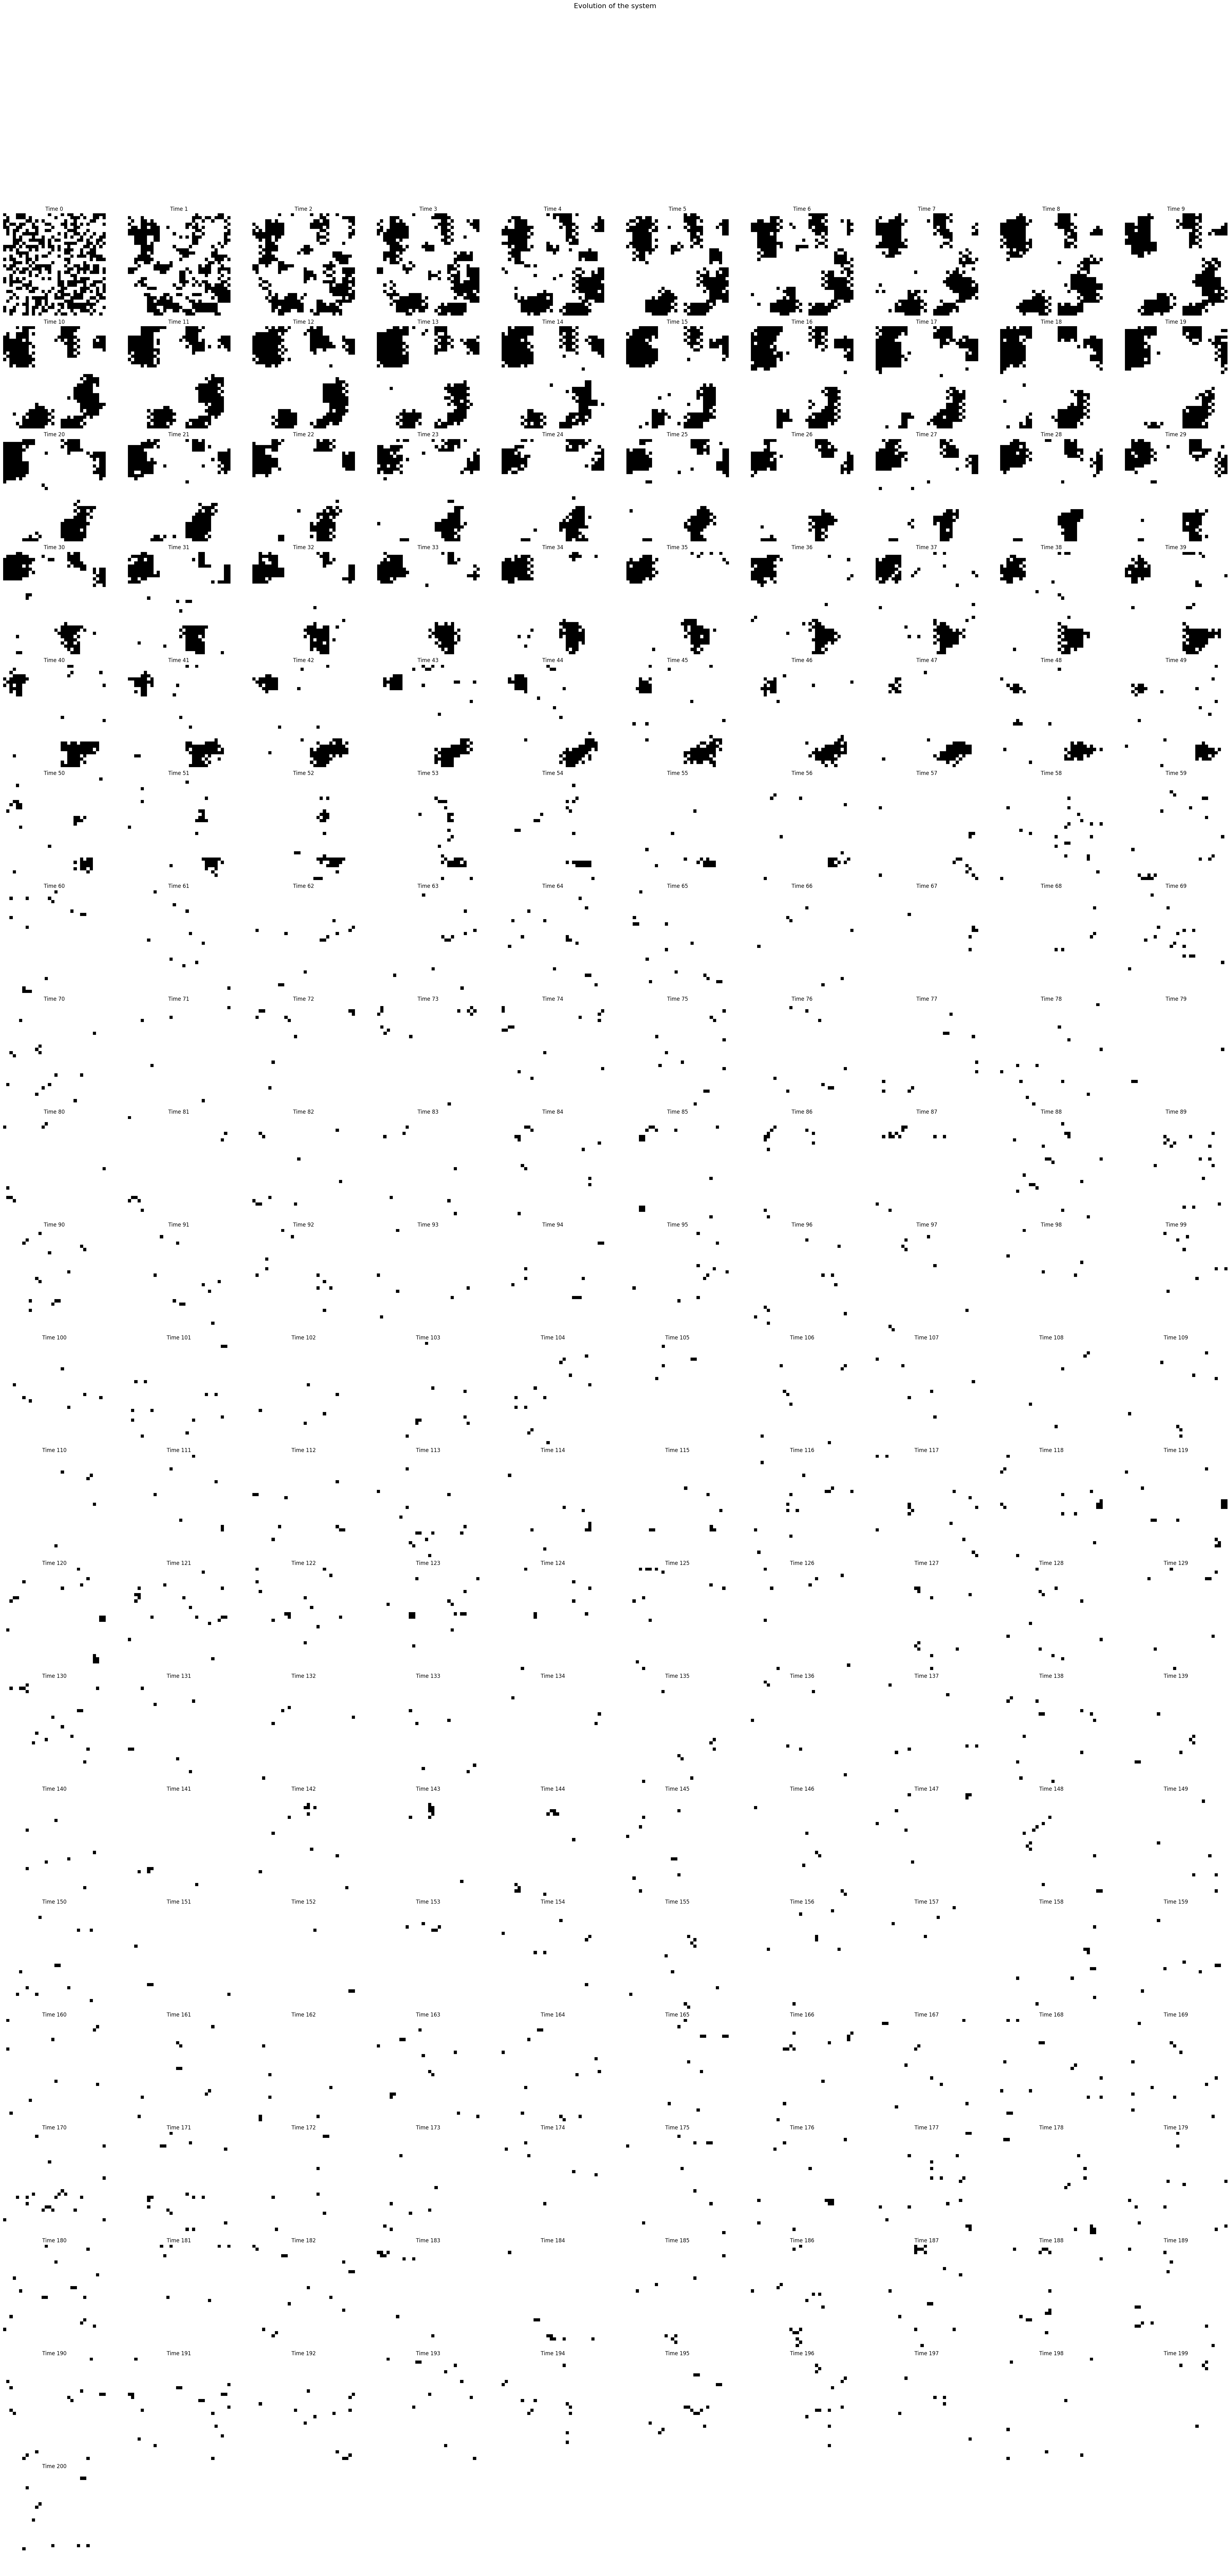

In [21]:
alpha = 0.2
reduced_alpha = -2 * beta * alpha

spin_system = SpinSystem(
    grid_height=grid_height,
    grid_width=grid_width,
    init_up=init_up,
    fraction_neutral= 0,  # pas d'agents neutres
    region_neutral="random"
)

magnetisation = empty((min(total_updates, MAX_FILE_SIZE), ), dtype=float)
magnetisation[:] = nan


full_grids = []
full_grids.append(reconstruct_grid(spin_system.black, spin_system.white))

for ii in range(total_updates):
    # update
    mag = spin_system.update(reduced_neighbour_coupling, reduced_alpha)
    full_grids.append(reconstruct_grid(spin_system.black, spin_system.white))
    magnetisation[ii % MAX_FILE_SIZE] = mag

    if ii > 0 and (ii % MAX_FILE_SIZE == 0):
        savetxt(f"magnetisation_{ii}.dat", magnetisation)
        magnetisation[:] = nan

plot_array_list(full_grids, max_cols=10)

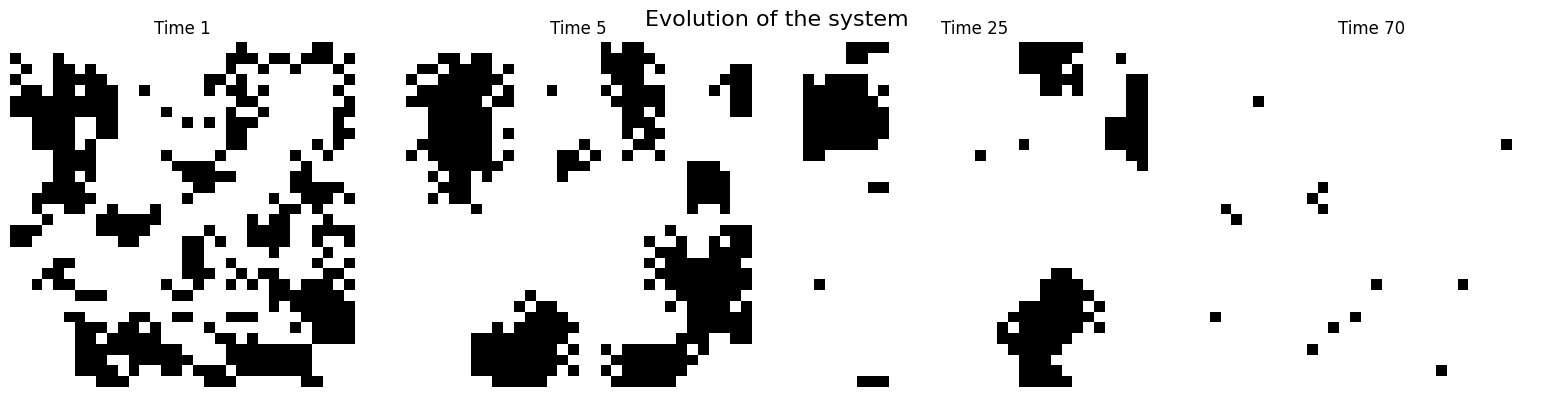

In [5]:
reduced_grid = [full_grids[1], full_grids[5], full_grids[25], full_grids[70]]
plot_array_list(reduced_grid, max_cols=10, timesteps=[1, 5, 25, 70])

### B. Alpha = 0.2, 25% of neutral agents

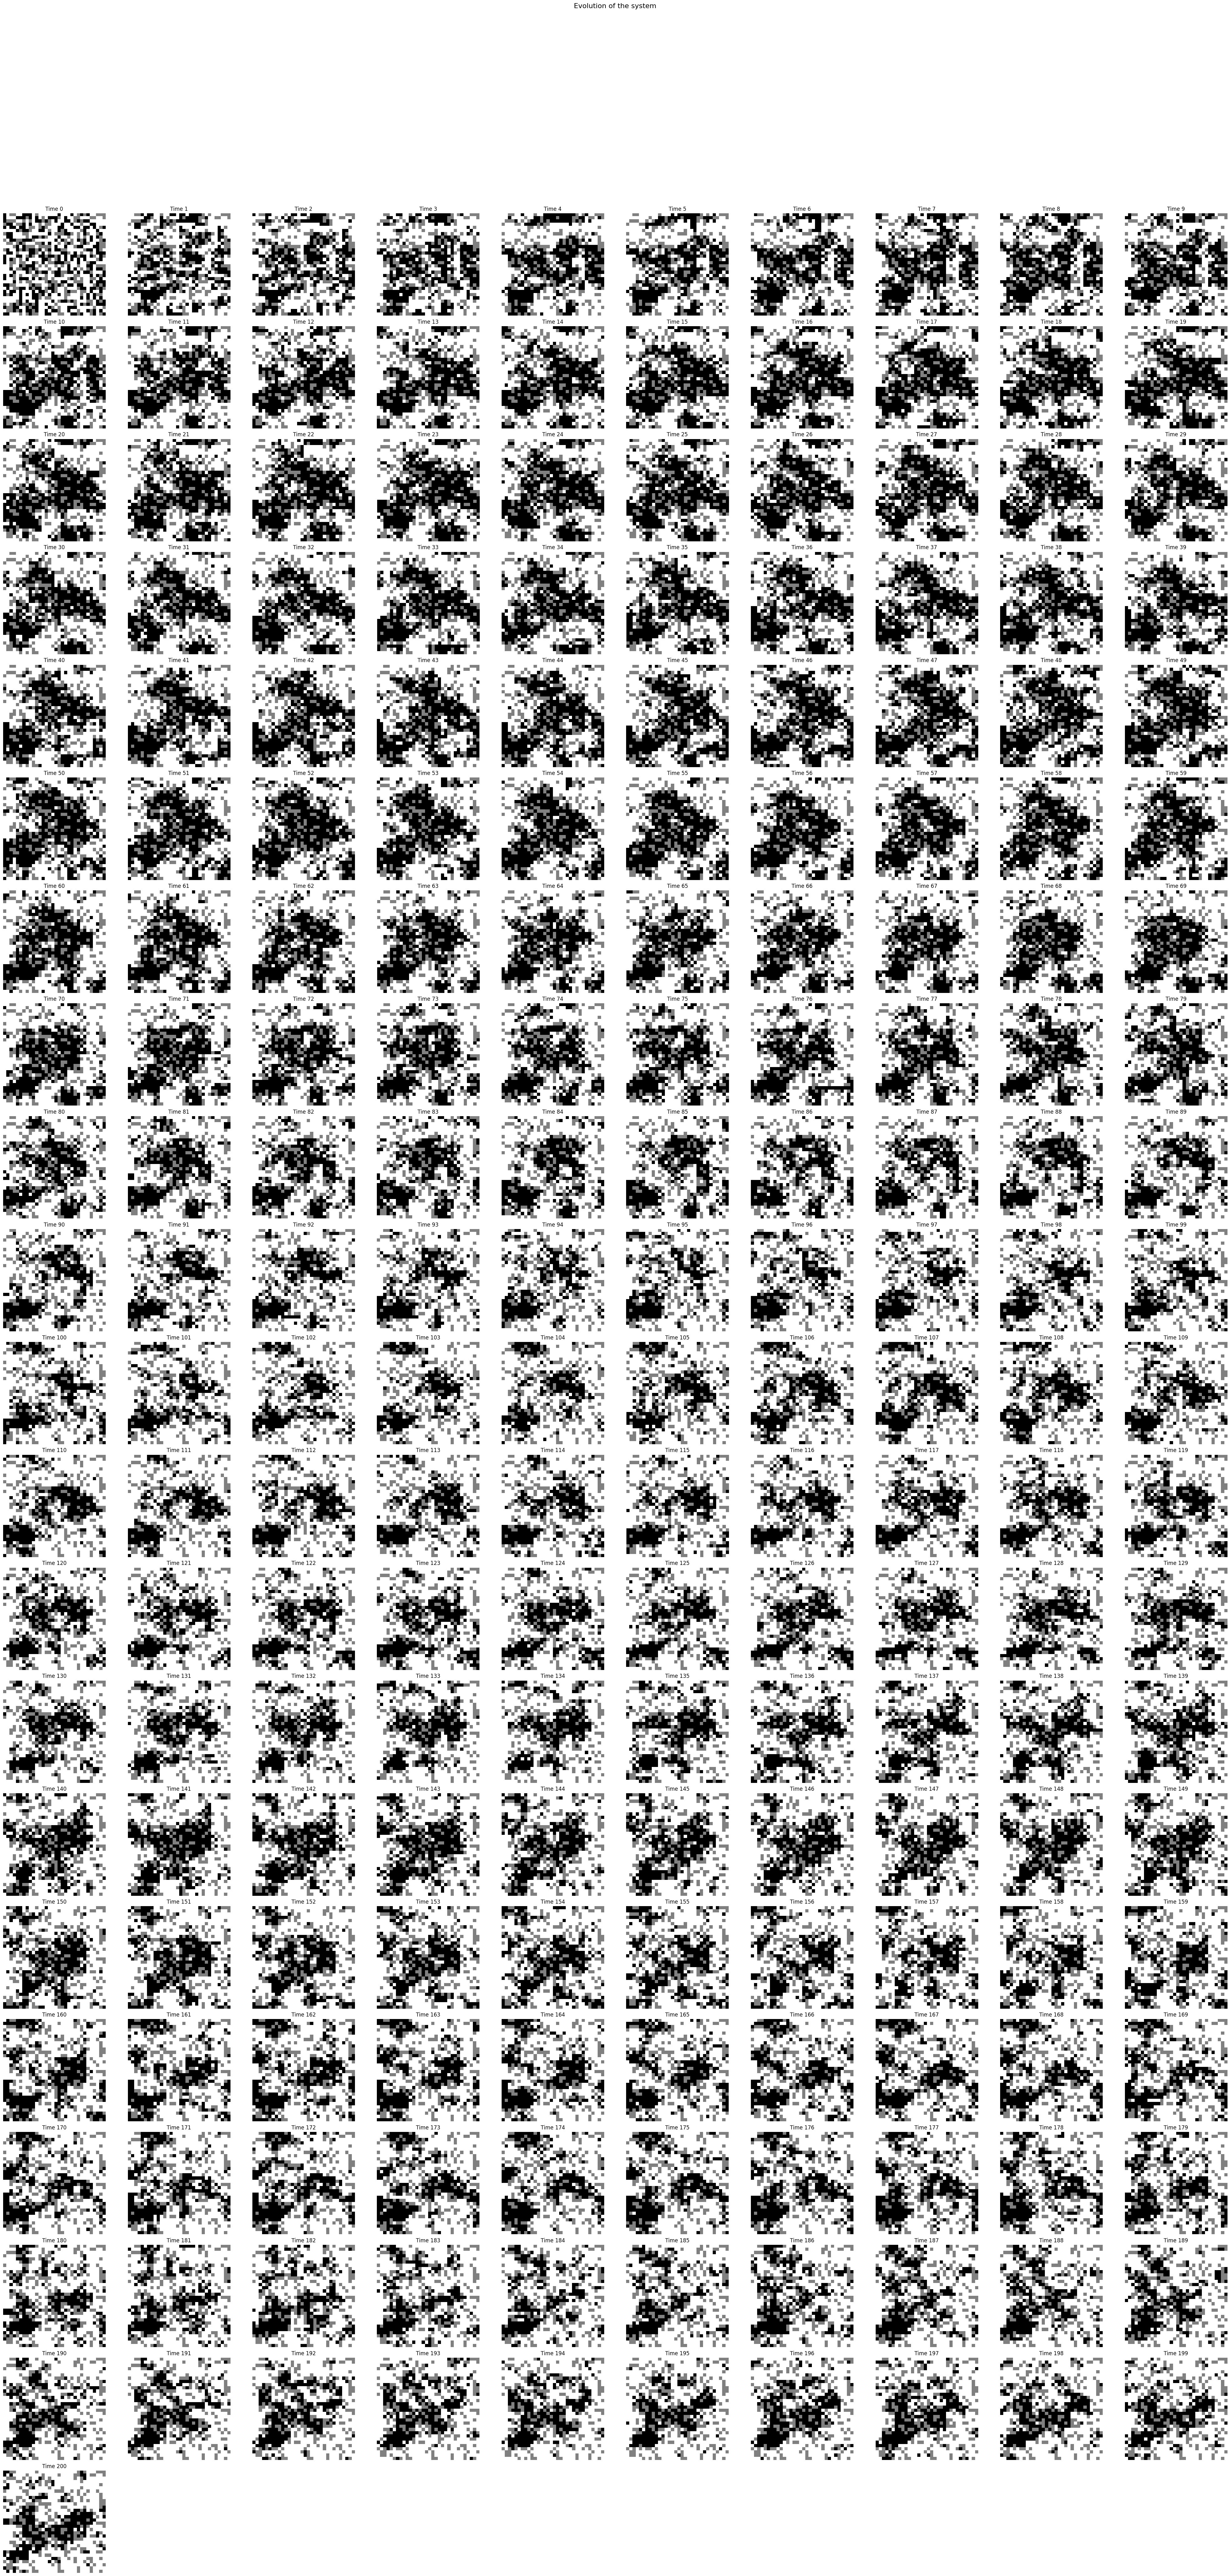

In [6]:
#fix the seed
SEED = 42
random.seed(SEED)       
np.random.seed(SEED) 

alpha = 0.2
reduced_alpha = -2 * beta * alpha

spin_system = SpinSystem(
    grid_height=grid_height,
    grid_width=grid_width,
    init_up=init_up,
    fraction_neutral= 0.25, 
    region_neutral="random"
)

magnetisation = empty((min(total_updates, MAX_FILE_SIZE), ), dtype=float)
magnetisation[:] = nan


full_grids = []
full_grids.append(reconstruct_grid(spin_system.black, spin_system.white))


for ii in range(total_updates):
    # update
    mag = spin_system.update(reduced_neighbour_coupling, reduced_alpha)
    full_grids.append(reconstruct_grid(spin_system.black, spin_system.white))
    magnetisation[ii % MAX_FILE_SIZE] = mag

    if ii > 0 and (ii % MAX_FILE_SIZE == 0):
        savetxt(f"magnetisation_{ii}.dat", magnetisation)
        magnetisation[:] = nan

plot_array_list(full_grids, max_cols=10)


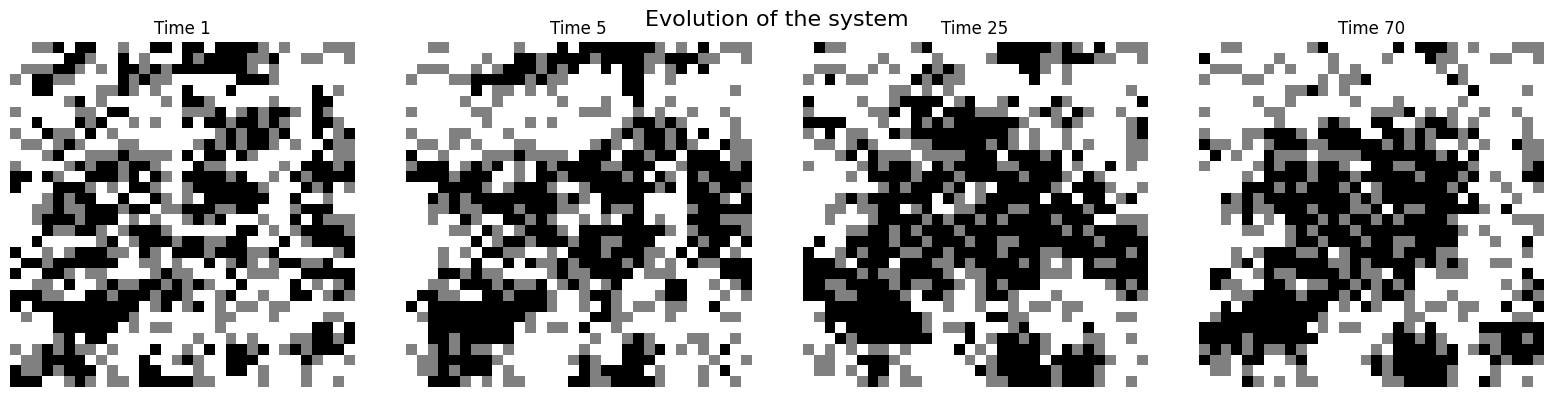

In [7]:
reduced_grid = [full_grids[1], full_grids[5], full_grids[25], full_grids[70]]
plot_array_list(reduced_grid, max_cols=10, timesteps=[1, 5, 25, 70])

### C. Alpha = 0.2, 4°% of neutral agents

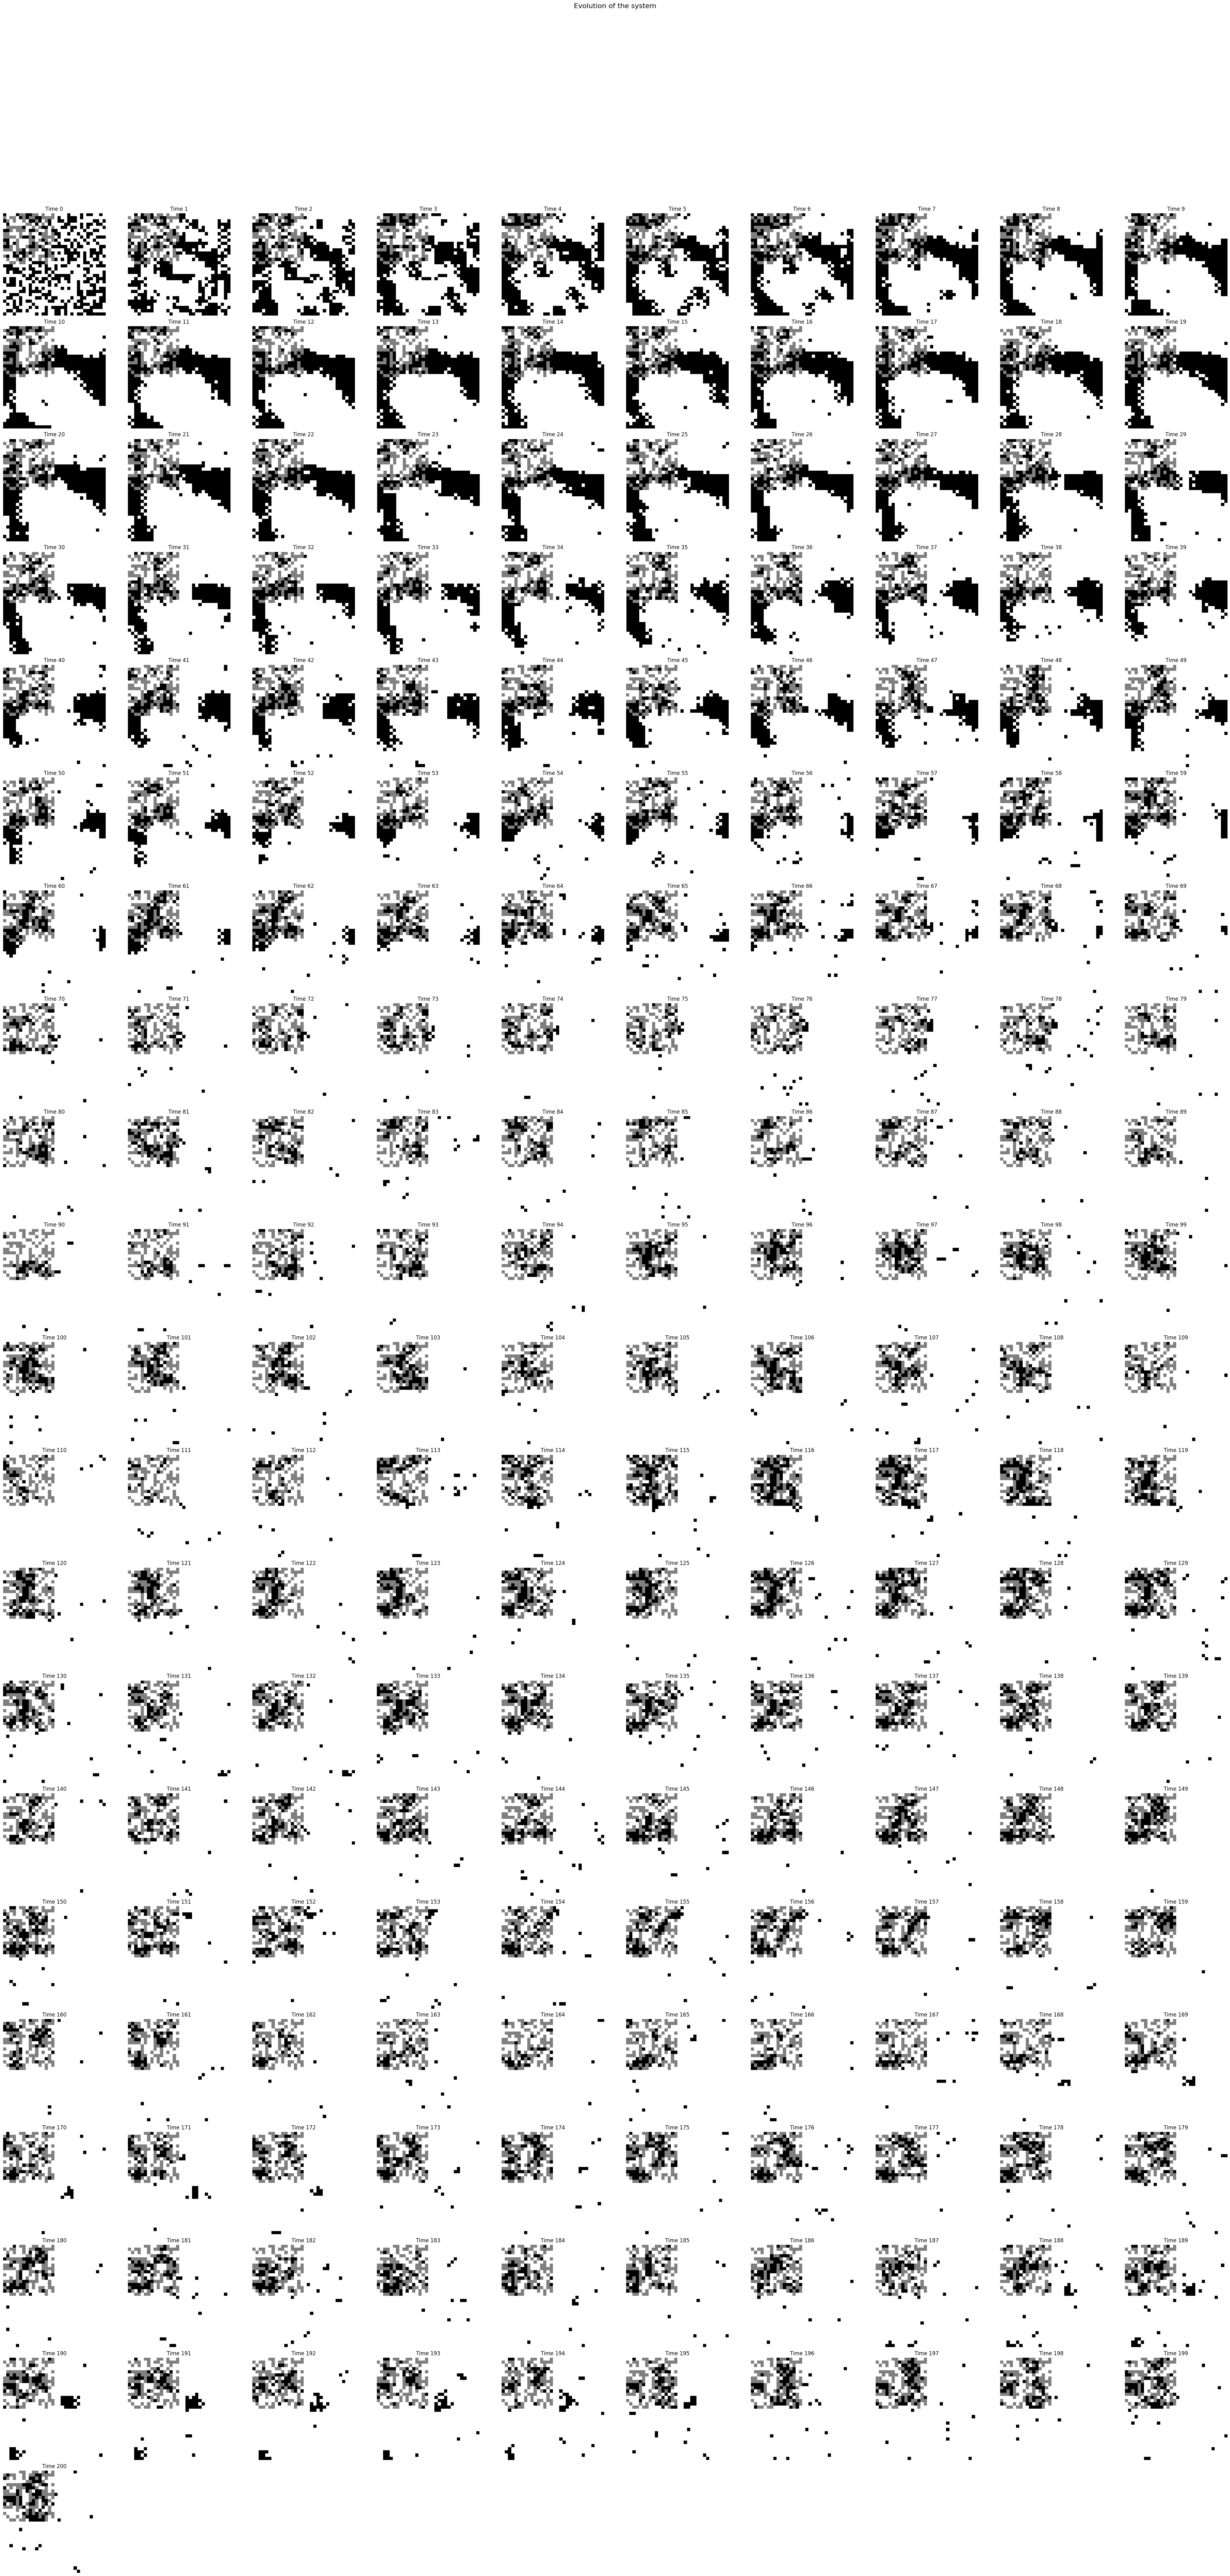

In [8]:
#fix the seed
SEED = 42
random.seed(SEED)       
np.random.seed(SEED) 

alpha = 0.2
reduced_alpha = -2 * beta * alpha

spin_system = SpinSystem(
    grid_height=grid_height,
    grid_width=grid_width,
    init_up=init_up,
    fraction_neutral= 0.4, 
    region_neutral="top_left"
)

magnetisation = empty((min(total_updates, MAX_FILE_SIZE), ), dtype=float)
magnetisation[:] = nan


full_grids = []
full_grids.append(reconstruct_grid(spin_system.black, spin_system.white))


for ii in range(total_updates):
    # update
    mag = spin_system.update(reduced_neighbour_coupling, reduced_alpha)
    full_grids.append(reconstruct_grid(spin_system.black, spin_system.white))
    magnetisation[ii % MAX_FILE_SIZE] = mag

    if ii > 0 and (ii % MAX_FILE_SIZE == 0):
        savetxt(f"magnetisation_{ii}.dat", magnetisation)
        magnetisation[:] = nan

plot_array_list(full_grids, max_cols=10)


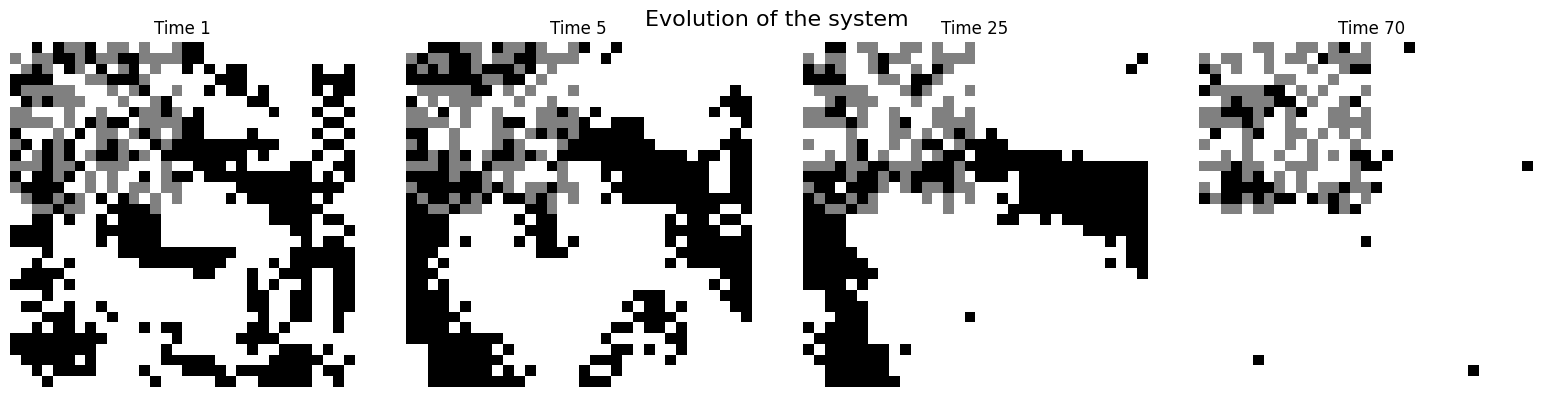

In [9]:
reduced_grid = [full_grids[1], full_grids[5], full_grids[25], full_grids[70]]
plot_array_list(reduced_grid, max_cols=10, timesteps=[1, 5, 25, 70])

### D. Comparison with different values of alpha and different fractions of neutrals

In [10]:
num_simulations = 10
neutral_percents = [0, 0.05, 0.25, 0.5] 
alpha_values = [0.2, 1, 4, 8]

def run_monte_carlo_simulation(region_neutral, neutral_percents, alpha_values):
    monte_carlo_timeseries = {p: {a: [] for a in alpha_values} for p in neutral_percents}

    for simulation in range(num_simulations):
        print(f"Running simulation {simulation+1}/{num_simulations}")
        for neutral_percent in neutral_percents:
            for alpha in alpha_values:
                SEED = 42 + simulation
                np.random.seed(SEED)
                random.seed(SEED)
                reduced_alpha = -2.0 * beta * alpha
                
                spin_system = SpinSystem(
                    grid_height=grid_height,
                    grid_width=grid_width,
                    init_up=init_up,
                    fraction_neutral=neutral_percent,
                    region_neutral=region_neutral)

                
                magnetisation = np.empty((min(total_updates, MAX_FILE_SIZE), ), dtype=float)
                magnetisation[:] = np.nan
                full_grid = []
                full_grid.append(reconstruct_grid(spin_system.black, spin_system.white))
                
                for ii in range(total_updates):
                    mag = spin_system.update(reduced_neighbour_coupling, reduced_alpha, excluding_neutrals=True)
                    magnetisation[ii % MAX_FILE_SIZE] = mag
                    full_grid.append(reconstruct_grid(spin_system.black, spin_system.white))
                
                if simulation == 0:
                    monte_carlo_timeseries[neutral_percent][alpha] = [magnetisation.copy()]
                else:
                    monte_carlo_timeseries[neutral_percent][alpha].append(magnetisation.copy())

    return monte_carlo_timeseries

def calculate_monte_carlo_stats(monte_carlo_timeseries, neutral_percents, alpha_values):
    mean_timeseries = {}
    ci_lower_timeseries = {}
    ci_upper_timeseries = {}

    for neutral_percent in neutral_percents:
        mean_timeseries[neutral_percent] = {}
        ci_lower_timeseries[neutral_percent] = {}
        ci_upper_timeseries[neutral_percent] = {}
        
        for alpha in alpha_values:
            all_simulations = np.array(monte_carlo_timeseries[neutral_percent][alpha])
            
            mean_timeseries[neutral_percent][alpha] = np.mean(all_simulations, axis=0)
            
            ci_lower = np.zeros_like(mean_timeseries[neutral_percent][alpha])
            ci_upper = np.zeros_like(mean_timeseries[neutral_percent][alpha])
            
            # confidence intervals for each time step
            for t in range(len(mean_timeseries[neutral_percent][alpha])):
                if not np.isnan(mean_timeseries[neutral_percent][alpha][t]):
                    t_values = all_simulations[:, t]
                    t_values = t_values[~np.isnan(t_values)]
                    
                    if len(t_values) > 1:
                        mean_val = np.mean(t_values)
                        ci = stats.t.interval(0.95, len(t_values)-1, loc=mean_val, scale=stats.sem(t_values))
                        ci_lower[t] = ci[0]
                        ci_upper[t] = ci[1]
                    else:
                        ci_lower[t] = mean_timeseries[neutral_percent][alpha][t]
                        ci_upper[t] = mean_timeseries[neutral_percent][alpha][t]
            
            ci_lower_timeseries[neutral_percent][alpha] = ci_lower
            ci_upper_timeseries[neutral_percent][alpha] = ci_upper

    return mean_timeseries, ci_lower_timeseries, ci_upper_timeseries


random_results = run_monte_carlo_simulation(region_neutral='random', neutral_percents=[0, 0.05, 0.25, 0.5], alpha_values=alpha_values)
top_left_results = run_monte_carlo_simulation(region_neutral='top_left', neutral_percents=[0, 0.1, 0.4, 0.8], alpha_values=alpha_values)

Running simulation 1/10
Running simulation 2/10
Running simulation 3/10
Running simulation 4/10
Running simulation 5/10
Running simulation 6/10
Running simulation 7/10
Running simulation 8/10
Running simulation 9/10
Running simulation 10/10
Running simulation 1/10
Running simulation 2/10
Running simulation 3/10
Running simulation 4/10
Running simulation 5/10
Running simulation 6/10
Running simulation 7/10
Running simulation 8/10
Running simulation 9/10
Running simulation 10/10


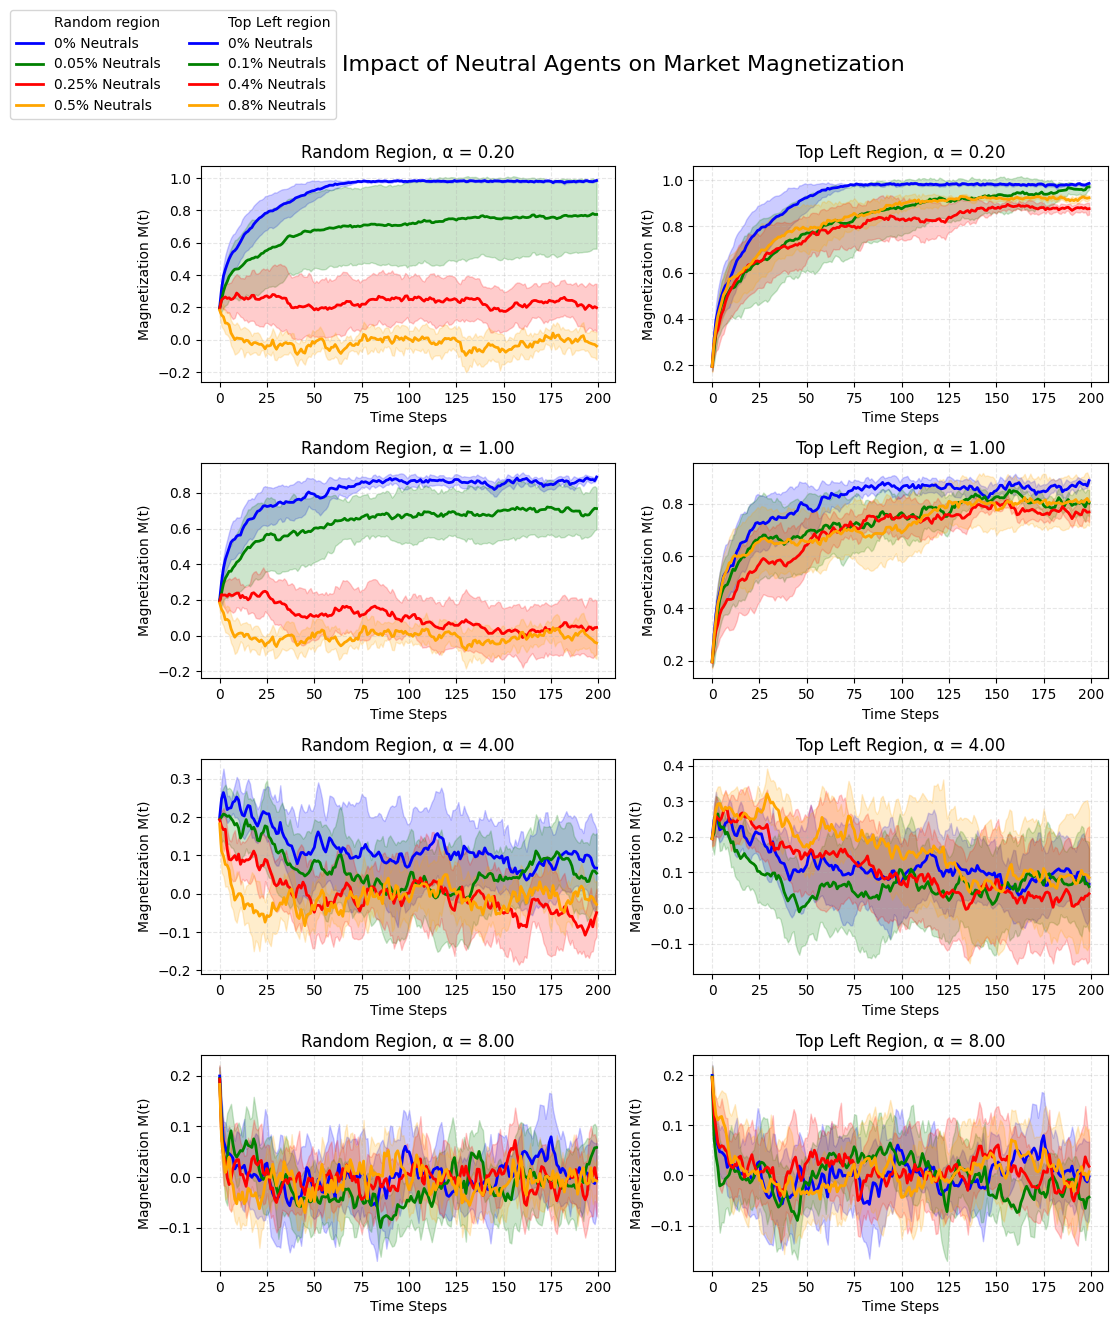

[<matplotlib.lines.Line2D object at 0x11b680530>, <matplotlib.lines.Line2D object at 0x11c10cc80>, <matplotlib.lines.Line2D object at 0x11c10f920>, <matplotlib.lines.Line2D object at 0x11bdbce90>, <matplotlib.lines.Line2D object at 0x119e5af30>, <matplotlib.lines.Line2D object at 0x11c773b30>, <matplotlib.lines.Line2D object at 0x11bec3230>, <matplotlib.lines.Line2D object at 0x11c770050>, <matplotlib.lines.Line2D object at 0x11c7725a0>, <matplotlib.lines.Line2D object at 0x11c771340>] ['Random region', '0% Neutrals', '0.05% Neutrals', '0.25% Neutrals', '0.5% Neutrals', 'Top Left region', '0% Neutrals', '0.1% Neutrals', '0.4% Neutrals', '0.8% Neutrals']


In [11]:
def plot_monte_carlo_results(random_results, top_left_results, neutral_percents_random, neutral_percents_top_left, alpha_values):
    num_rows = len(alpha_values)
    num_cols = 2  
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 3*num_rows + 1))
    fig.suptitle("Impact of Neutral Agents on Market Magnetization", fontsize=16)
    
    color_palette = ['blue', 'green', 'red', 'orange']
    
    regions = ['Random', 'Top Left']
    all_results = [random_results, top_left_results]
    all_neutral_percents = [neutral_percents_random, neutral_percents_top_left]
    
    legend_handles = []
    legend_labels = []
    
    for region_idx, (region_name, region_results, neutral_percents) in enumerate(zip(regions, all_results, all_neutral_percents)):

        mean_timeseries, ci_lower_timeseries, ci_upper_timeseries = calculate_monte_carlo_stats(
            region_results, neutral_percents, alpha_values
        )
        for alpha_idx, alpha in enumerate(alpha_values):
            ax = axs[alpha_idx, region_idx] if num_rows > 1 else axs[region_idx]
            
            ax.clear()
            
            ax.set_title(f"{region_name} Region, α = {alpha:.2f}")

            for percent_idx, neutral_percent in enumerate(neutral_percents):
                color = color_palette[percent_idx]
                
                time_steps = np.arange(len(mean_timeseries[neutral_percent][alpha]))
                mean_data = mean_timeseries[neutral_percent][alpha]
                lower_ci = ci_lower_timeseries[neutral_percent][alpha]
                upper_ci = ci_upper_timeseries[neutral_percent][alpha]
                
                line = ax.plot(time_steps, mean_data,
                        color=color,
                        linewidth=2)[0]
                
                ax.fill_between(time_steps, lower_ci, upper_ci,
                                color=color, alpha=0.2)
                
                if alpha_idx == 0:
                    if percent_idx==0: 
                        legend_labels.append(f'{region_name} region')
                        legend_handles.append(ax.plot(time_steps, mean_data,
                                        color='white',
                                        linewidth=0.005)[0])
                    legend_handles.append(line)
                    legend_labels.append(f'{neutral_percent}% Neutrals')
            
            ax.set_xlabel("Time Steps")
            ax.set_ylabel("Magnetization M(t)")
            ax.grid(True, linestyle='--', alpha=0.3)
    
    fig.legend(legend_handles, legend_labels, 
               loc='upper center', 
               bbox_to_anchor=(0.05, 1.02), 
               ncol=2,
               fontsize=10)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    print(legend_handles, legend_labels)
plot_monte_carlo_results(random_results, top_left_results, neutral_percents_random= [0, 0.05, 0.25, 0.5], neutral_percents_top_left=[0, 0.1, 0.4, 0.8], alpha_values=alpha_values)


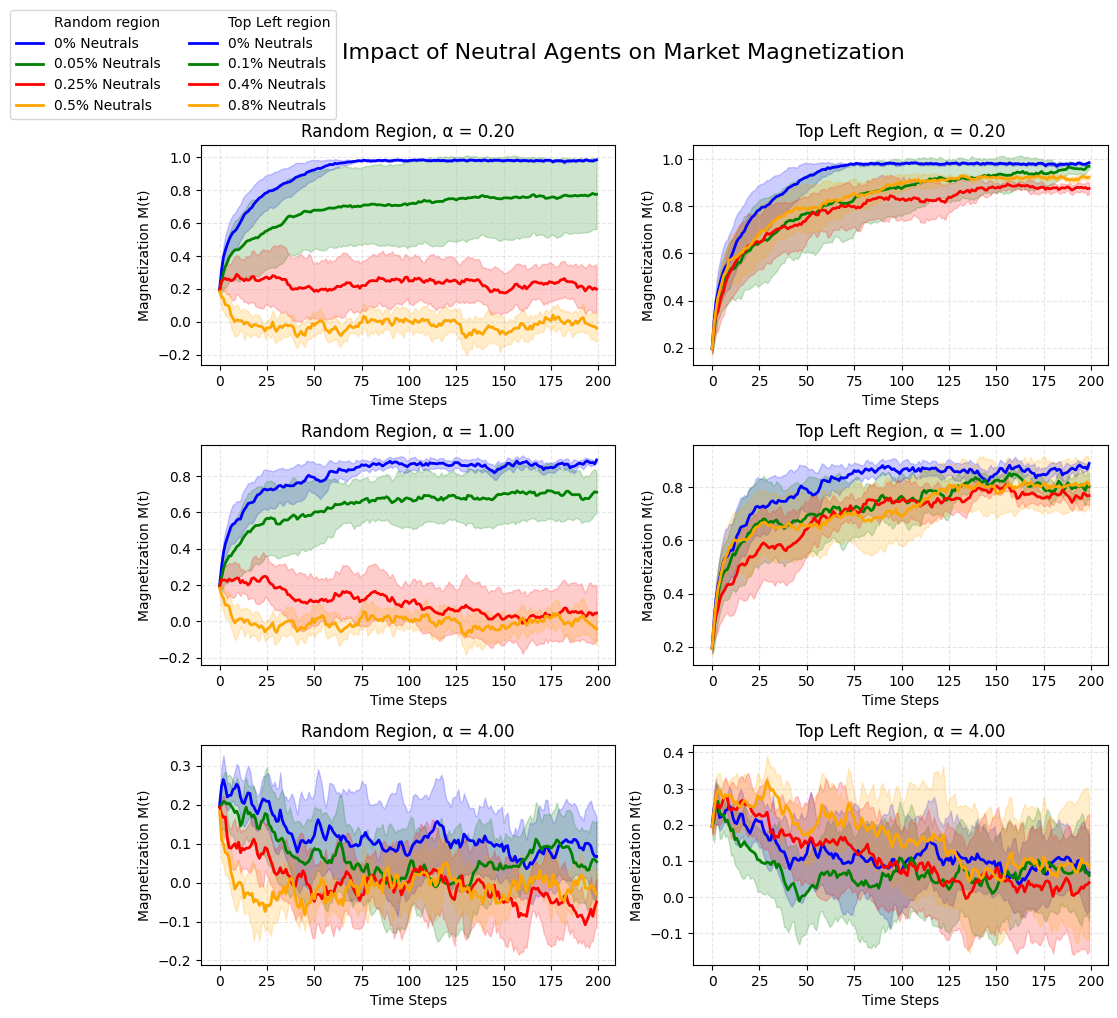

[<matplotlib.lines.Line2D object at 0x11adb2ed0>, <matplotlib.lines.Line2D object at 0x11b42e180>, <matplotlib.lines.Line2D object at 0x11abe8a10>, <matplotlib.lines.Line2D object at 0x11abe81a0>, <matplotlib.lines.Line2D object at 0x11abe8230>, <matplotlib.lines.Line2D object at 0x11beed790>, <matplotlib.lines.Line2D object at 0x11a6fa300>, <matplotlib.lines.Line2D object at 0x11beee4e0>, <matplotlib.lines.Line2D object at 0x11beedd00>, <matplotlib.lines.Line2D object at 0x11beee150>] ['Random region', '0% Neutrals', '0.05% Neutrals', '0.25% Neutrals', '0.5% Neutrals', 'Top Left region', '0% Neutrals', '0.1% Neutrals', '0.4% Neutrals', '0.8% Neutrals']


In [12]:
plot_monte_carlo_results(random_results, top_left_results, neutral_percents_random= [0, 0.05, 0.25, 0.5], neutral_percents_top_left=[0, 0.1, 0.4, 0.8], alpha_values=alpha_values[:-1])